 # BBM418 Assignment 4 Tiny DETR

 # Name: Ahmet Oğuzhan Kökülü

 # Student ID: 2220356053

In [7]:
import os
import random
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torchvision.ops as ops 
import pandas as pd 

# Install torchmetrics
try:
    from torchmetrics.detection.mean_ap import MeanAveragePrecision
except ImportError:
    import subprocess
    subprocess.check_call(["pip", "install", "torchmetrics"])
    from torchmetrics.detection.mean_ap import MeanAveragePrecision

# Global Config
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Running on: {DEVICE}")

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)


Running on: cuda


 ## 1. Dataset Class

In [8]:
class PennFudanDataset(Dataset):
    def __init__(self, root_dir, split='train', transforms=None, use_augmentation=False):
        self.root_dir = root_dir
        self.transforms = transforms
        self.use_augmentation = use_augmentation
        
        split_path = os.path.join(root_dir, "splits/"+split+".txt")
        # Generate splits if missing
        if not os.path.exists(split_path):
             os.makedirs(os.path.join(root_dir, "splits"), exist_ok=True)
             all_imgs = sorted([f.split('.')[0] for f in os.listdir(os.path.join(root_dir, "Pedestrian")) if f.endswith(".png")])
             random.shuffle(all_imgs)
             n = len(all_imgs)
             if split == 'train': imgs = all_imgs[:int(n*0.7)]
             elif split == 'val': imgs = all_imgs[int(n*0.7):int(n*0.85)]
             else: imgs = all_imgs[int(n*0.85):]
             with open(split_path, "w") as f: f.write("\n".join(imgs))

        with open(split_path, "r") as split_file:
            content = split_file.read()
            self.images = content.splitlines() if "\n" in content else content.split()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx].split(".")[0]
        image_path = os.path.join(self.root_dir, "Pedestrian/"+img_name+".png")
        annotation_path = os.path.join(self.root_dir, "Pedestrian/"+img_name+".txt")

        image = Image.open(image_path).convert("RGB")
        width, height = image.size

        bounding_boxes = []
        with open(annotation_path) as ann:
            for line in ann:
                if "Bounding box" in line:
                    import re
                    bounding_box_coor = re.findall(r'\d+', line.split(":")[1])
                    bounding_boxes.append([int(x) for x in bounding_box_coor])

        bounding_boxes = torch.as_tensor(bounding_boxes, dtype=torch.float32)

        # --- 1. GEOMETRIC AUGMENTATION (Manual) ---
        if self.use_augmentation:
            # Random Scale/Crop
            if random.random() > 0.5:
                scale = random.uniform(0.6, 1.0)
                new_w, new_h = int(width * scale), int(height * scale)
                x_off = random.randint(0, width - new_w)
                y_off = random.randint(0, height - new_h)
                
                image = image.crop((x_off, y_off, x_off + new_w, y_off + new_h))
                
                if len(bounding_boxes) > 0:
                    bounding_boxes[:, 0] -= x_off
                    bounding_boxes[:, 1] -= y_off
                    bounding_boxes[:, 2] -= x_off
                    bounding_boxes[:, 3] -= y_off
                    bounding_boxes[:, 0].clamp_(0, new_w)
                    bounding_boxes[:, 1].clamp_(0, new_h)
                    bounding_boxes[:, 2].clamp_(0, new_w)
                    bounding_boxes[:, 3].clamp_(0, new_h)
                    
                    keep = (bounding_boxes[:, 2] > bounding_boxes[:, 0] + 5) & \
                           (bounding_boxes[:, 3] > bounding_boxes[:, 1] + 5)
                    bounding_boxes = bounding_boxes[keep]
                
                width, height = new_w, new_h

            # Horizontal Flip
            if random.random() > 0.5:
                image = image.transpose(Image.FLIP_LEFT_RIGHT)
                if len(bounding_boxes) > 0:
                    new_xmin = width - bounding_boxes[:, 2]
                    new_xmax = width - bounding_boxes[:, 0]
                    bounding_boxes[:, 0] = new_xmin
                    bounding_boxes[:, 2] = new_xmax

        # Normalize boxes
        coordinates = []
        for box in bounding_boxes:
            xmin, ymin, xmax, ymax = box
            box_w = xmax - xmin
            box_h = ymax - ymin
            cx = xmin + box_w / 2
            cy = ymin + box_h / 2
            coordinates.append([cx/width, cy/height, box_w/width, box_h/height])

        box_tensor = torch.as_tensor(coordinates, dtype=torch.float32)
        if len(box_tensor) == 0:
            box_tensor = torch.zeros((0, 4), dtype=torch.float32)

        target = {}
        target["boxes"] = box_tensor
        target["labels"] = torch.ones(len(coordinates), dtype=torch.int64)
        target["image_id"] = torch.tensor([idx])
        target["orig_size"] = torch.tensor([height, width]) 

        # Apply Visual Transforms
        if self.transforms is not None:
            image = self.transforms(image)
        
        return image, target

def collat_func(batch):
    images, targets = list(zip(*batch))
    images = torch.stack(images)
    return images, targets


 ## 2. Flexible TinyDETR Model

In [9]:
class TinyDETR(nn.Module):
    def __init__(self, backbone_name, num_queries, num_classes, hidden_dim, nheads, num_encoder_layers, num_decoder_layers):
        super().__init__()
        self.backbone_name = backbone_name

        if backbone_name == "resnet18":
            raw_model = resnet18(weights=ResNet18_Weights.DEFAULT)
            # Dilation for ResNet
            raw_model.layer4[0].conv1.stride = (1, 1)
            raw_model.layer4[0].downsample[0].stride = (1, 1)
            self.backbone = nn.Sequential(*list(raw_model.children())[:-2])
            backbone_channels = 512
            
        elif backbone_name == "mobilenet_v2":
            raw_model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
            self.backbone = raw_model.features
            backbone_channels = 1280
        else:
            raise ValueError(f"Unknown backbone: {backbone_name}")
        
        # Unfreeze weights
        for param in self.backbone.parameters():
            param.requires_grad = True

        self.conv = nn.Conv2d(backbone_channels, hidden_dim, kernel_size=1)
        self.transformer = nn.Transformer(hidden_dim, nheads, num_encoder_layers, num_decoder_layers)
        
        # Initialization
        self.query_pos = nn.Parameter(torch.zeros(num_queries, hidden_dim))
        nn.init.xavier_uniform_(self.query_pos)
        
        self.class_head = nn.Linear(hidden_dim, num_classes+1)
        self.bbox_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, 4)
        )

    def train(self, mode=True):
        super().train(mode)
        if mode:
            # Keep backbone weights trainable but freeze BN
            self.backbone.train()
            for module in self.backbone.modules():
                if isinstance(module, torch.nn.BatchNorm2d):
                    module.eval()

    def encode_position(self, d_model, height, width, device):
        x_pos = torch.arange(width, dtype=torch.float32, device=device)
        y_pos = torch.arange(height, dtype=torch.float32, device=device)
        dim_t = torch.arange(0, d_model//2, 2, dtype=torch.float32, device=device)
        div_term = torch.exp(dim_t * (-torch.log(torch.tensor(10000.0)) / (d_model // 2)))
        
        poen_x = torch.zeros(width, d_model//2, device=device)
        poen_x[:, 0::2] = torch.sin(x_pos.unsqueeze(1) * div_term)
        poen_x[:, 1::2] = torch.cos(x_pos.unsqueeze(1) * div_term)
        
        poen_y = torch.zeros(height, d_model // 2, device=device)
        poen_y[:, 0::2] = torch.sin(y_pos.unsqueeze(1) * div_term)
        poen_y[:, 1::2] = torch.cos(y_pos.unsqueeze(1) * div_term)

        poen_x = poen_x.unsqueeze(0).repeat(height, 1, 1)
        poen_y = poen_y.unsqueeze(1).repeat(1, width, 1)
        
        poen = torch.cat([poen_x, poen_y], dim=2)
        return poen.permute(2, 0, 1).unsqueeze(0)
        
    def forward(self, x):
        # Force BN eval
        for module in self.backbone.modules():
            if isinstance(module, torch.nn.BatchNorm2d):
                module.eval()

        features = self.backbone(x)
        h = self.conv(features) 
        B, C, H, W = h.shape
        pos_enc = self.encode_position(C, H, W, h.device)
        
        src = (h + pos_enc).flatten(2).permute(2, 0, 1)
        query_embed = self.query_pos.unsqueeze(1).repeat(1, B, 1)

        hs = self.transformer(src, query_embed)
        hs = hs.permute(1, 0, 2)
        
        return {'pred_logits': self.class_head(hs), 'pred_boxes': self.bbox_head(hs).sigmoid()}


 ## 3. Loss & Matching Utilities

In [10]:
def box_c_to_xy(x):
    cx, cy, w, h = x.unbind(-1)
    b = [(cx - 0.5 * w), (cy - 0.5 * h), (cx + 0.5 * w), (cy + 0.5 * h)]
    return torch.stack(b, dim=-1)

def generalized_iou(boxes1, boxes2):
    area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1]) 
    area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1]) 
    lt = torch.max(boxes1[:, :2].unsqueeze(1), boxes2[:, :2].unsqueeze(0))
    rb = torch.min(boxes1[:, 2:].unsqueeze(1), boxes2[:, 2:].unsqueeze(0))
    wh = (rb - lt).clamp(min=0) 
    inter = wh[:, :, 0] * wh[:, :, 1] 
    union = area1.unsqueeze(1) + area2.unsqueeze(0) - inter
    iou = inter / union
    lt_c = torch.min(boxes1[:, :2].unsqueeze(1), boxes2[:, :2].unsqueeze(0))
    rb_c = torch.max(boxes1[:, 2:].unsqueeze(1), boxes2[:, 2:].unsqueeze(0))
    wh_c = (rb_c - lt_c).clamp(min=0)
    area_c = wh_c[:, :, 0] * wh_c[:, :, 1]
    return iou - ((area_c - union) / (area_c + 1e-6))

class HungarianMatcher(nn.Module):
    def __init__(self, cost_class=1, cost_bbox=5, cost_giou=2):
        super().__init__()
        self.w_class, self.w_bbox, self.w_giou = cost_class, cost_bbox, cost_giou

    @torch.no_grad()
    def forward(self, outputs, targets):
        bs = outputs["pred_logits"].shape[0]
        indices = []
        for i in range(bs):
            probs = outputs["pred_logits"][i].softmax(-1)
            pred_boxes = outputs["pred_boxes"][i]
            tgt_ids = targets[i]["labels"]
            tgt_boxes = targets[i]["boxes"]
            cost_class = -probs[:, tgt_ids]
            cost_bbox = torch.cdist(pred_boxes, tgt_boxes, p=1)
            cost_giou = -generalized_iou(box_c_to_xy(pred_boxes), box_c_to_xy(tgt_boxes))
            C = self.w_bbox * cost_bbox + self.w_class * cost_class + self.w_giou * cost_giou
            row, col = linear_sum_assignment(C.cpu().numpy())
            indices.append((torch.as_tensor(row, dtype=torch.int64), torch.as_tensor(col, dtype=torch.int64)))
        return indices

class SetCriterion(nn.Module):
    def __init__(self, num_classes, matcher, weight_dict, eos_coef):
        super().__init__()
        self.num_classes = num_classes
        self.matcher = matcher
        self.weight_dict = weight_dict
        empty_weight = torch.ones(self.num_classes + 1)
        empty_weight[0] = eos_coef
        self.register_buffer('empty_weight', empty_weight)

    def forward(self, outputs, targets):
        indices = self.matcher(outputs, targets)
        num_boxes = sum(len(t["labels"]) for t in targets)
        num_boxes = torch.as_tensor([num_boxes], dtype=torch.float, device=outputs['pred_logits'].device)
        num_boxes = torch.clamp(num_boxes, min=1).item()
        
        src_logits = outputs['pred_logits']
        idx = self._get_src_permutation_idx(indices)
        target_classes = torch.zeros(src_logits.shape[:2], dtype=torch.int64, device=src_logits.device)
        target_classes[idx] = torch.cat([t['labels'][J] for t, (_, J) in zip(targets, indices)])
        
        loss_ce = F.cross_entropy(src_logits.transpose(1, 2), target_classes, self.empty_weight)
        src_boxes = outputs['pred_boxes'][idx]
        target_boxes = torch.cat([t['boxes'][i] for t, (_, i) in zip(targets, indices)], dim=0)
        loss_bbox = F.l1_loss(src_boxes, target_boxes, reduction='none').sum() / num_boxes
        loss_giou = (1 - generalized_iou(box_c_to_xy(src_boxes), box_c_to_xy(target_boxes)).diag()).sum() / num_boxes

        return {'loss_ce': loss_ce, 'loss_bbox': loss_bbox, 'loss_giou': loss_giou}

    def _get_src_permutation_idx(self, indices):
        batch_idx = torch.cat([torch.full_like(src, i) for i, (src, _) in enumerate(indices)])
        src_idx = torch.cat([src for (src, _) in indices])
        return batch_idx, src_idx


 ## 4. Main Experiment Runner

In [11]:
def run_experiment(exp_name, backbone, num_queries, use_aug, epochs, batch_size=4):
    print(f"\n{'='*20} RUNNING: {exp_name} {'='*20}")
    
    # 1. Clean Memory
    torch.cuda.empty_cache()
    
    # 2. Transforms & Datasets
    stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    if use_aug:
        train_transform = T.Compose([
            T.Resize((512, 512)),
            T.RandomApply([T.ColorJitter(0.5, 0.5, 0.5, 0.1)], p=0.8),
            T.RandomGrayscale(p=0.2),
            T.RandomApply([T.GaussianBlur((5, 9))], p=0.5),
            T.ToTensor(), T.Normalize(*stats)
        ])
    else:
        train_transform = T.Compose([T.Resize((512, 512)), T.ToTensor(), T.Normalize(*stats)])
    
    val_transform = T.Compose([T.Resize((512, 512)), T.ToTensor(), T.Normalize(*stats)])

    root = "ignore"
    train_ds = PennFudanDataset(root, split='train', transforms=train_transform, use_augmentation=use_aug)
    val_ds = PennFudanDataset(root, split='val', transforms=val_transform, use_augmentation=False)
    
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collat_func)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=collat_func)

    # 3. Model & Optimizer
    model = TinyDETR(backbone, num_queries, 1, 256, 8, 2, 2).to(DEVICE)
    matcher = HungarianMatcher(cost_class=1, cost_bbox=5, cost_giou=2)
    criterion = SetCriterion(1, matcher, {'loss_ce': 2.0, 'loss_bbox': 5, 'loss_giou': 2}, eos_coef=0.1).to(DEVICE)
    
    optimizer = optim.AdamW([
        {"params": [p for n, p in model.named_parameters() if "backbone" in n and p.requires_grad], "lr": 1e-5},
        {"params": [p for n, p in model.named_parameters() if "backbone" not in n and p.requires_grad], "lr": 1e-4},
    ], weight_decay=1e-4)
    
    metric = MeanAveragePrecision(box_format="xyxy", iou_type="bbox", class_metrics=True).to(DEVICE)

    # 4. Training Loop
    loss_history = []
    map_history = []
    best_map = 0.0
    start = time.time()

    for epoch in range(epochs):
        model.train()
        ep_loss = 0
        for imgs, tgts in train_loader:
            imgs = imgs.to(DEVICE)
            tgts = [{k: v.to(DEVICE) for k, v in t.items()} for t in tgts]
            optimizer.zero_grad()
            out = model(imgs)
            loss_dict = criterion(out, tgts)
            loss = sum(loss_dict[k] * criterion.weight_dict[k] for k in loss_dict.keys())
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            optimizer.step()
            ep_loss += loss.item()
        
        loss_history.append(ep_loss / len(train_loader))

        # Validate
        if (epoch + 1) % 5 == 0 or epoch == epochs - 1:
            model.eval()
            metric.reset()
            with torch.no_grad():
                for imgs, tgts in val_loader:
                    imgs = imgs.to(DEVICE)
                    tgts = [{k: v.to(DEVICE) for k, v in t.items()} for t in tgts]
                    out = model(imgs)
                    pred_l, tgt_l = [], []
                    for i in range(len(imgs)):
                        probs = out['pred_logits'][i].softmax(-1)
                        scores = probs[:, 1]
                        labels = torch.zeros_like(scores, dtype=torch.long)
                        boxes = box_c_to_xy(out['pred_boxes'][i])
                        h, w = tgts[i]['orig_size']
                        boxes[:, 0::2] *= w
                        boxes[:, 1::2] *= h
                        pred_l.append(dict(boxes=boxes, scores=scores, labels=labels))
                        
                        tgt_b = box_c_to_xy(tgts[i]['boxes'])
                        tgt_b[:, 0::2] *= w
                        tgt_b[:, 1::2] *= h
                        tgt_l.append(dict(boxes=tgt_b, labels=(tgts[i]['labels']-1).to(DEVICE)))
                    metric.update(pred_l, tgt_l)
            
            val_map = metric.compute()['map_50'].item()
            map_history.append(val_map)
            print(f"Ep {epoch+1}: Loss {loss_history[-1]:.4f} | mAP {val_map:.4f}")
            
            if val_map > best_map:
                best_map = val_map
                # --- CHANGE: Save EVERY experiment's best model ---
                torch.save(model.state_dict(), f"{exp_name}_best.pth")

    total_time = time.time() - start
    
    # Cleanup memory
    model.to('cpu')
    del optimizer
    torch.cuda.empty_cache()
    
    return {
        "name": exp_name,
        "best_map": best_map,
        "time_per_epoch": total_time / epochs,
        "loss_hist": loss_history,
        "map_hist": map_history,
    }


 ## 5. Run All Experiments (Section 4)

In [12]:
# CONFIGURATION
EPOCHS = 100

results = {}

# 1. Baseline MobileNet (Ablation)
results['MobileNet'] = run_experiment("MobileNetV2", "mobilenet_v2", 20, True, EPOCHS)

# 2. ResNet vs MobileNet (Ablation)
results['ResNet_20q'] = run_experiment("ResNet18_20q", "resnet18", 20, True, EPOCHS)

# 3. Query Ablation (20 vs 50)
results['ResNet_50q'] = run_experiment("ResNet18_50q", "resnet18", 50, True, EPOCHS)

# 4. Augmentation Ablation (With vs Without)
results['ResNet_NoAug'] = run_experiment("ResNet18_NoAug", "resnet18", 20, False, EPOCHS)

# 5. BEST MODEL TRAINING
print("\nTRAINING FINAL BEST MODEL (Long Run)...")
results['Final_Best'] = run_experiment("ResNet18_Best", "resnet18", 20, True, EPOCHS)



==================== RUNNING: MobileNetV2 ====================


/home/oguzhan/Projects/BBM416_Projects/Fourth_Assignment/venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Ep 5: Loss 3.3259 | mAP 0.2570
Ep 10: Loss 3.2727 | mAP 0.1845
Ep 15: Loss 3.0283 | mAP 0.2630
Ep 20: Loss 3.1288 | mAP 0.2215
Ep 25: Loss 3.0784 | mAP 0.2374
Ep 30: Loss 3.1086 | mAP 0.0770
Ep 35: Loss 2.8877 | mAP 0.2107
Ep 40: Loss 2.6919 | mAP 0.2690
Ep 45: Loss 2.7684 | mAP 0.3225
Ep 50: Loss 2.6326 | mAP 0.2904
Ep 55: Loss 2.4959 | mAP 0.3763
Ep 60: Loss 2.2885 | mAP 0.3432
Ep 65: Loss 2.2960 | mAP 0.3667
Ep 70: Loss 2.2047 | mAP 0.4034
Ep 75: Loss 2.1300 | mAP 0.3543
Ep 80: Loss 1.9280 | mAP 0.4665
Ep 85: Loss 1.8690 | mAP 0.4830
Ep 90: Loss 1.8721 | mAP 0.5598
Ep 95: Loss 1.8549 | mAP 0.5434
Ep 100: Loss 1.8146 | mAP 0.5351

==================== RUNNING: ResNet18_20q ====================
Ep 5: Loss 3.4188 | mAP 0.2431
Ep 10: Loss 3.1866 | mAP 0.3016
Ep 15: Loss 3.1377 | mAP 0.2044
Ep 20: Loss 3.0874 | mAP 0.2106
Ep 25: Loss 3.1153 | mAP 0.1376
Ep 30: Loss 3.0035 | mAP 0.1601
Ep 35: Loss 2.9103 | mAP 0.2233
Ep 40: Loss 2.8376 | mAP 0.1864
Ep 45: Loss 2.8512 | mAP 0.1858
Ep 50: L

 ## 6. Results & Tables (Section 6)


Experiment           | Best mAP   | Time/Ep   
------------------------------------------------------------
MobileNet            | 0.5598     | 5.10s
ResNet (Base)        | 0.5856     | 6.38s
ResNet (50q)         | 0.2659     | 6.48s
ResNet (NoAug)       | 0.4573     | 4.74s
Final Best           | 0.5790     | 6.40s


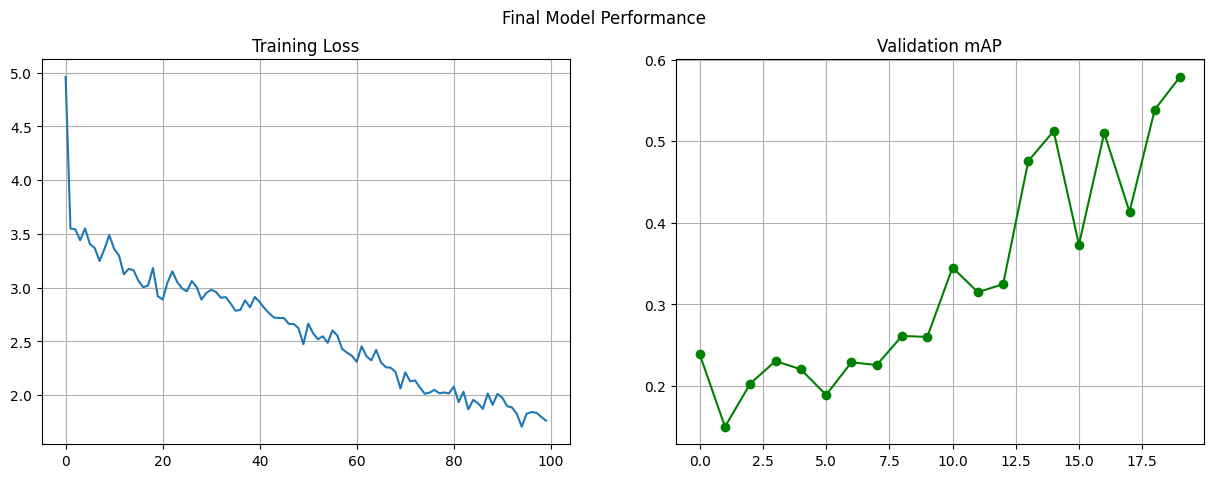

Loading 'ResNet18_Best_best.pth' for Final Evaluation...

>>> FINAL TEST SET mAP@0.5: 0.5257 <<<


In [17]:
# 1. Comparison Table
print("\n" + "="*60)
print(f"{'Experiment':<20} | {'Best mAP':<10} | {'Time/Ep':<10}")
print("-" * 60)

experiments = [
    ('MobileNet', results['MobileNet']),
    ('ResNet (Base)', results['ResNet_20q']),
    ('ResNet (50q)', results['ResNet_50q']),
    ('ResNet (NoAug)', results['ResNet_NoAug']),
    ('Final Best', results['Final_Best'])
]

for name, res in experiments:
    print(f"{name:<20} | {res['best_map']:.4f}     | {res['time_per_epoch']:.2f}s")
print("="*60)

# 2. Plot Training Curves (Final Model)
final_res = results['Final_Best']
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(final_res['loss_hist'], label='Loss')
ax[0].set_title('Training Loss')
ax[0].grid(True)
ax[1].plot(final_res['map_hist'], label='mAP@0.5', color='green', marker='o')
ax[1].set_title('Validation mAP')
ax[1].grid(True)
plt.suptitle("Final Model Performance")
plt.show()

# 3. Final Test Evaluation (Loads Best Model Weights)
test_transform = T.Compose([T.Resize((512, 512)), T.ToTensor(), T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
test_ds = PennFudanDataset("ignore", split='test', transforms=test_transform, use_augmentation=False)
test_loader = DataLoader(test_ds, batch_size=4, shuffle=False, collate_fn=collat_func)

print("Loading 'ResNet18_Best_best.pth' for Final Evaluation...")
model = TinyDETR("resnet18", 20, 1, 256, 8, 2, 2).to(DEVICE)
model.load_state_dict(torch.load("ResNet18_Best_best.pth"))
model.eval()
metric = MeanAveragePrecision(box_format="xyxy", iou_type="bbox", class_metrics=True).to(DEVICE)

with torch.no_grad():
    for imgs, tgts in test_loader:
        imgs = imgs.to(DEVICE)
        out = model(imgs)
        pred_l, tgt_l = [], []
        for i in range(len(imgs)):
            probs = out['pred_logits'][i].softmax(-1)
            scores = probs[:, 1]
            labels = torch.zeros_like(scores, dtype=torch.long)
            boxes = box_c_to_xy(out['pred_boxes'][i])
            h, w = tgts[i]['orig_size']
            boxes[:, 0::2] *= w
            boxes[:, 1::2] *= h
            pred_l.append(dict(boxes=boxes, scores=scores, labels=labels))
            
            tgt_b = box_c_to_xy(tgts[i]['boxes']).to(DEVICE)
            tgt_b[:, 0::2] *= w
            tgt_b[:, 1::2] *= h
            tgt_l.append(dict(boxes=tgt_b, labels=(tgts[i]['labels']-1).to(DEVICE)))
        metric.update(pred_l, tgt_l)

test_map = metric.compute()['map_50'].item()
print(f"\n>>> FINAL TEST SET mAP@0.5: {test_map:.4f} <<<")


 ## 7. Qualitative Grid Visualization

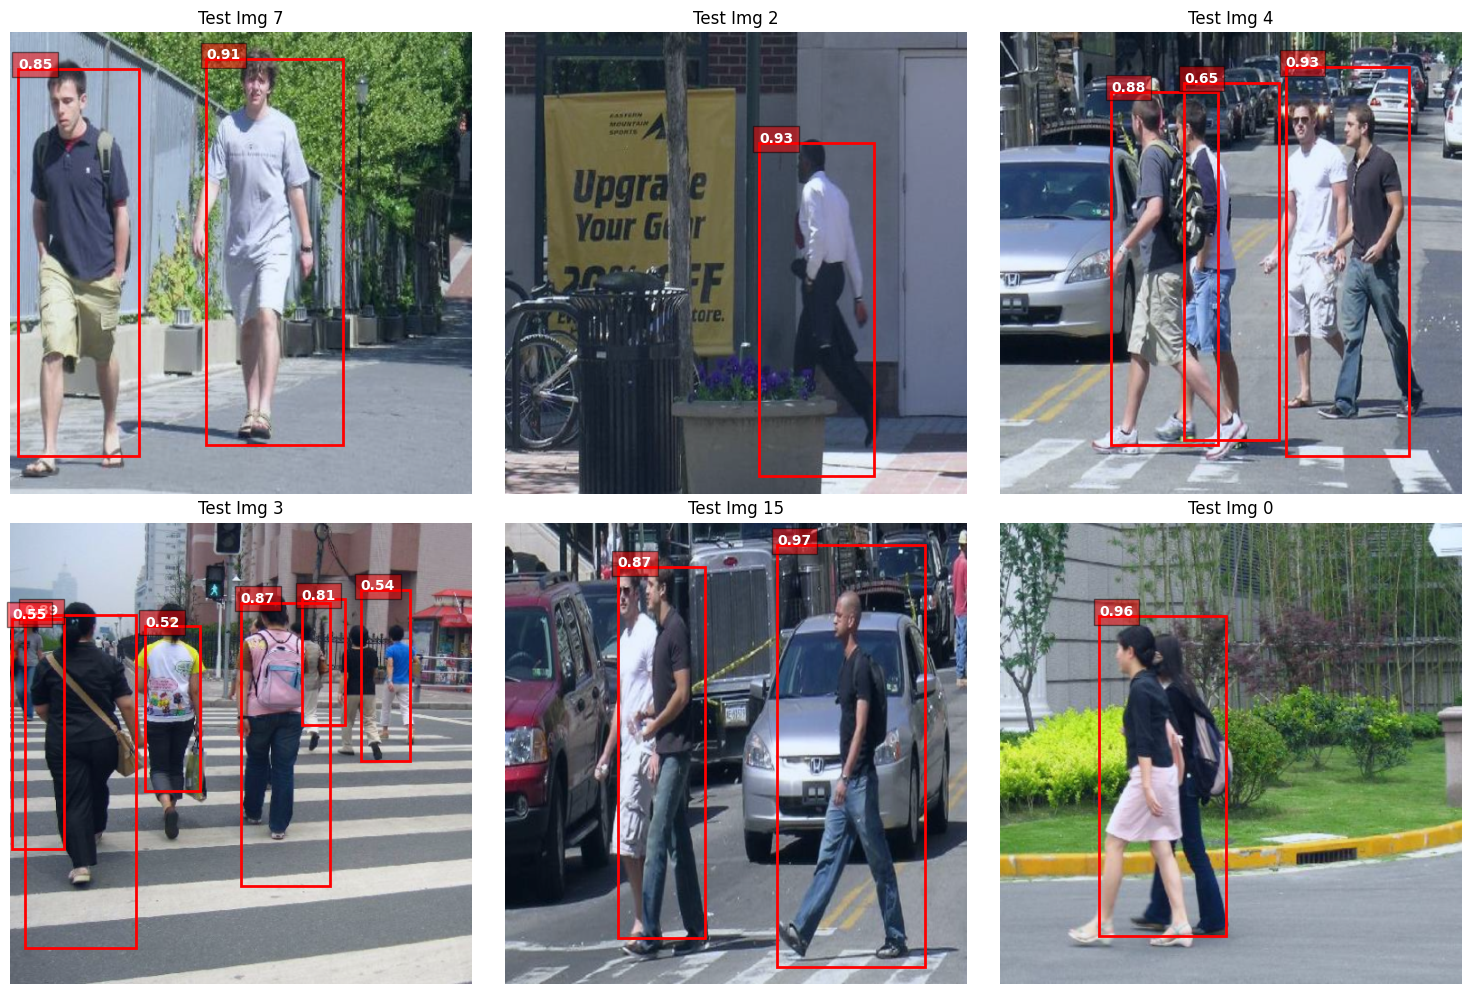

In [19]:
def visualize_grid(model, dataset, num_images=6):
    model = model.to(DEVICE) 
    model.eval()
    indices = random.sample(range(len(dataset)), num_images)
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, idx in enumerate(indices):
        img, _ = dataset[idx]
        with torch.no_grad():
            out = model(img.unsqueeze(0).to(DEVICE))
        
        probs = out['pred_logits'].softmax(-1)[0, :, 1]
        boxes = out['pred_boxes'][0]
        
        img_np = img.permute(1, 2, 0).cpu().numpy()
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
        h, w, _ = img_np.shape
        
        boxes_xyxy = box_c_to_xy(boxes)
        boxes_xyxy[:, 0::2] *= w
        boxes_xyxy[:, 1::2] *= h
        
        # NMS
        keep = ops.nms(boxes_xyxy, probs, 0.3)
        keep = keep[probs[keep] > 0.5]
        
        axes[i].imshow(img_np)
        for k in keep:
            xmin, ymin, xmax, ymax = boxes_xyxy[k].tolist()
            rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=2, edgecolor='red', facecolor='none')
            axes[i].add_patch(rect)
            axes[i].text(xmin, ymin, f"{probs[k]:.2f}", color='white', fontweight='bold', bbox=dict(facecolor='red', alpha=0.5))
        axes[i].axis('off')
        axes[i].set_title(f"Test Img {idx}")
    plt.tight_layout()
    plt.show()

visualize_grid(model, test_ds)